# Review Sentiment Analysis and Rating Prediction on DrugReview Dataset

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
import review_preprocess
import summarize_review
from matplotlib import pyplot as plt
from sklearn.preprocessing import OneHotEncoder,LabelEncoder
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
import keras
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from xgboost import  XGBClassifier
from sklearn.metrics import accuracy_score

print("Setup Done..")

Setup Done..


## Loading our data_set
- please change path according to your directory

In [3]:
train_file_name = 'drugsComTrain_raw.csv'
test_file_name = 'drugsComTest_raw.csv'
file_path = './data/'

df_test = pd.read_csv(file_path+test_file_name)
df_train = pd.read_csv(file_path+train_file_name)

## Our data set Description
- the dataset was generated using web crawlers
- the dataset consists of DrugName, condition and a review column along with rating
- For example : if condition of patient is Obesity , then the drug prescribed to him is Contrave

In [4]:
#Print one example row of dataset
df_train[df_train.condition == 'Obesity'].iloc[1]

uniqueID                                                   39795
drugName                                                Contrave
condition                                                Obesity
review         "I am just finishing my second week taking Con...
rating                                                         8
date                                                    4-Nov-15
usefulCount                                                    9
Name: 41, dtype: object

In [5]:
df_train.head()

,uniqueID,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,20-May-12,27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,27-Apr-10,192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,14-Dec-09,17
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,3-Nov-15,10
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,27-Nov-16,37


## PreProcess DataSet:

- What Pre-process does?
        - It removes rows with NA values (we decided to remove since
            the number of such rows is ver less)
        - It replaces garbage characters (( &#039; ,!,?,  &quot; , \r \n )) 
            with appropriate values
        - It then returns cleaned dataframe

In [5]:
# Print a review before cleaning
df_test.review[8]

'"Ive been on Methadone for over ten years and currently,I am trying to get off of this drug. Ive been decreasing my does 2 mgs per month for over a year. I am at 3 mgs and really starting to feel the withdraw.I don&#039;t plan to get my next 30 doses.because its almost rediculous how little it does for me. I have 3 does doses of 3 mg and Im terrified. Can anyone give me some truthful encouragement?....."'

In [6]:
df_test = review_preprocess.clean_reviews(df_test)
df_train = review_preprocess.clean_reviews(df_train)

Review cleanup Completed...aracters from review column--> 100.0 percentage complete
Removing row with nan values
Percentage of nan rows in dataset--> 0.55 %
Removed 295 rows with na values
Review cleanup Completed...aracters from review column--> 100.0 percentage complete
Removing row with nan values
Percentage of nan rows in dataset--> 0.56 %
Removed 899 rows with na values


In [7]:
# Print a review after cleaning
df_test.review[8]

"'Ive been on Methadone for over ten years and currently I am trying to get off of this drug. Ive been decreasing my does 2 mgs per month for over a year. I am at 3 mgs and really starting to feel the withdraw.I don't plan to get my next 30 doses.because its almost rediculous how little it does for me. I have 3 does doses of 3 mg and Im terrified. Can anyone give me some truthful encouragement  .'"

# Summarize our review.
- After Cleaning our review , we try to summarize it

In [8]:
%%time
import multiprocessing as mp

print("Number of processors using: ", mp.cpu_count()-1)
pool = mp.Pool(mp.cpu_count()-1)
rows,_ = df_train.shape


print("starting summarization of training set")
summary_v=np.vectorize(summarize_review.summarize)
short_review = pool.map(summary_v, df_train.review.values)
pool.close()
print("Summarization of training set COMPLETE....")

print("starting summarization of test set")
pool = mp.Pool(mp.cpu_count())
short_review_test = pool.map(summary_v, df_test.review.values)
pool.close()
print("Summarization of test set COMPLETE....")


df_train["summarize"] = np.array(short_review)
df_test["summarize"] = np.array(short_review_test)

Number of processors using:  15
starting summarization of training set
Summarization of training set COMPLETE....
starting summarization of test set
Summarization of test set COMPLETE....
CPU times: user 3.13 s, sys: 2.06 s, total: 5.19 s
Wall time: 3min 44s


In [9]:
print('-------original review-------')
print(df_test.review[10])
print('\n')
print('-------summarized review-------')
print(df_test.summarize[10])

-------original review-------
'Holy Hell is exactly how I feel. I had been taking Brisdelle for 1.5 years. The hot flashes did indeed subside - however  the side affects of this medicine coupled with the fact Noven was acquired by YET another pharmaceutical company - YOU CAN'T PLACE A REP IN THE AREA  DISTRIBUTE YOUR DRUGS  AND THEN FIRE HER-AND NOT REPLACE THEREFORE there is NO medicine or support here. You dumped this drug in the Dr's hands and walked away. After calling Sebula - you act like you don't even care. You have made it impossible to obtain this. I happen to think this is illegal.  I just decided to wean myself off this and Premarin. It has been nothing short of a nightmare. If you don't need this drug- DON'T START. Seriously.'


-------summarized review-------
 You have made it impossible to obtain this. I happen to think this is illegal. I just decided to wean myself off this and Premarin. It has been nothing short of a nightmare. If you don't need this drug- DON'T START.

# Creating Sentiment column
- We create a sentiment column using Vader-SentimentIntensityAnalyzer
- More details on Vader analyzer are in report
- We use it to generate ground_truth for sentiment prediction from our models.

In [10]:
%%time

import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sid = SentimentIntensityAnalyzer()
# Create list (cast to array) of compound polarity sentiment scores for reviews
sentiments = []
for i in df_train.summarize:
    if sid.polarity_scores(i).get('compound') < -0.5 :
        sentiments.append('negative')
    elif sid.polarity_scores(i).get('compound') < 0.5 :
        sentiments.append('neutral')
    elif sid.polarity_scores(i).get('compound') <= 1 :
        sentiments.append('positive')

sentiments_test = []
for i in df_test.summarize:
    if sid.polarity_scores(i).get('compound') < -0.5 :
        sentiments_test.append('negative')
    elif sid.polarity_scores(i).get('compound') < 0.5 :
        sentiments_test.append('neutral')
    elif sid.polarity_scores(i).get('compound') <= 1 :
        sentiments_test.append('positive')

sentiments_test = np.array(sentiments_test)
sentiments = np.array(sentiments)

df_train["sentiment"] = sentiments
df_test["sentiment"] = sentiments_test

CPU times: user 2min 51s, sys: 0 ns, total: 2min 51s
Wall time: 2min 51s


In [11]:
# How our dataset looks like
df_train.head()

,uniqueID,drugName,condition,review,rating,date,usefulCount,summarize,sentiment
0,206461,Valsartan,Left Ventricular Dysfunction,'It has no side effect I take it in combinati...,9,20-May-12,27,'It has no side effect I take it in combinat...,neutral
1,95260,Guanfacine,ADHD,'My son is halfway through his fourth week of ...,8,27-Apr-10,192,See how he did at school and with getting up...,positive
2,92703,Lybrel,Birth Control,'I used to take another oral contraceptive wh...,5,14-Dec-09,17,And the period lasted for two weeks. When tak...,positive
3,138000,Ortho Evra,Birth Control,'This is my first time using any form of birth...,8,3-Nov-15,10,'This is my first time using any form of birt...,neutral
4,35696,Buprenorphine / naloxone,Opiate Dependence,'Suboxone has completely turned my life around...,9,27-Nov-16,37,All that is history. Slight constipation is a...,positive


# Vectorizing our review column

### - why vectorize?
       1). Our Review column contains reviews of different lengths
           We do this to convert each review into same size (dimensions).
       
       2). Vectorizing involves Tokenizing and then padding each sentence sequence.
           We have aprox. 49K unique words in our review column so,
           the number of features should be around 49K after vectorizing.
       
### - TF-IDF vectorizer :
- we have used TF-IDF vectorizer . More Details about TF-IDF are present in the Project Report
- It can be considered as the helper function which helps us vectorizing reveiws.

In [12]:
# Creates TF-IDF vectorizer and transforms the corpus
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(df_train.review)

# transforms test reviews to above vectorized format
X_test = vectorizer.transform(df_test.review)
print("Vectorizing done")

Vectorizing done


In [13]:
# Creates TF-IDF vectorizer and transforms the corpus
vectorizer_sum = TfidfVectorizer()
X_train_summary = vectorizer_sum.fit_transform(df_train.summarize)

# transforms test reviews to above vectorized format
X_test_summary = vectorizer_sum.transform(df_test.summarize)
print("Vectorizing done")

Vectorizing done


In [14]:
print("Test Shape : ",X_test.shape)
print("Train Shape :",X_train.shape)
print("We can see that every review in\
test and train Dataset have equal number of features now")

Test Shape :  (53471, 49853)
Train Shape : (160398, 49853)
We can see that every review intest and train Dataset have equal number of features now


In [15]:
print("Test Shape : ",X_test_summary.shape)
print("Train Shape :",X_train_summary.shape)
print("We can see that every review in\
test and train Dataset have equal number of features now")

Test Shape :  (53471, 29209)
Train Shape : (160398, 29209)
We can see that every review intest and train Dataset have equal number of features now


## The number of features are reduced in summary .
- The number of features in summary are 29209
- Number of features in original reviews are 49853

In [16]:
# Assign labels y_train and y_test
y_train = df_train.rating.copy(deep=True)
y_test = df_test.rating.copy(deep=True)


# Train our models to predict Rating
- we train our models on full review and summary of review 

## Random Forest Classifier
- we have performed a grid seach to obtain optimal number of trees and m (number of features per tree)

In [17]:
%%time
# Training on full review

_,features = X_test.shape
accuracy_list = {}


## our grid exaustive search parameters
m_features_names = ["2 sqrt(M)", "sqrt(M)", "log2(M)"]
m_features = [int(2*math.sqrt(features)), int(math.sqrt(features)), int(math.log2(features))]
num_trees = [20,50,100]

for m,m_name in zip(m_features,m_features_names):
    accuracy_list[m_name] = []
    for tr in num_trees:
        rfc_rating = RandomForestClassifier(n_estimators=tr,max_features=m,n_jobs=-1,verbose=3, random_state=42 )
        rfc_rating.fit(X_train, y_train)
        accuracy = rfc_rating.score(X_test, y_test)
        accuracy_list[m_name].append(accuracy)



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.


building tree 1 of 20
building tree 2 of 20
building tree 3 of 20
building tree 4 of 20
building tree 5 of 20
building tree 6 of 20
building tree 7 of 20
building tree 8 of 20
building tree 9 of 20
building tree 10 of 20
building tree 11 of 20
building tree 12 of 20
building tree 13 of 20
building tree 14 of 20
building tree 15 of 20
building tree 16 of 20
building tree 17 of 20
building tree 18 of 20
building tree 19 of 20


[Parallel(n_jobs=-1)]: Done   3 out of  20 | elapsed:   23.5s remaining:  2.2min


building tree 20 of 20


[Parallel(n_jobs=-1)]: Done  10 out of  20 | elapsed:   23.7s remaining:   23.7s
[Parallel(n_jobs=-1)]: Done  17 out of  20 | elapsed:   38.6s remaining:    6.8s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   38.9s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   3 out of  20 | elapsed:    0.1s remaining:    0.6s
[Parallel(n_jobs=16)]: Done  10 out of  20 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=16)]: Done  17 out of  20 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=16)]: Done  20 out of  20 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.


building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 

[Parallel(n_jobs=-1)]: Done  36 out of  50 | elapsed:  1.2min remaining:   27.4s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  1.4min finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  36 out of  50 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=16)]: Done  50 out of  50 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.


building tree 1 of 100building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100

building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
b

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.6min finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.


building tree 1 of 20
building tree 2 of 20
building tree 3 of 20
building tree 4 of 20
building tree 5 of 20
building tree 6 of 20
building tree 7 of 20
building tree 8 of 20
building tree 9 of 20
building tree 10 of 20
building tree 11 of 20
building tree 12 of 20
building tree 13 of 20
building tree 14 of 20
building tree 15 of 20
building tree 16 of 20
building tree 17 of 20
building tree 18 of 20
building tree 19 of 20
building tree 20 of 20


[Parallel(n_jobs=-1)]: Done   3 out of  20 | elapsed:   17.7s remaining:  1.7min
[Parallel(n_jobs=-1)]: Done  10 out of  20 | elapsed:   17.9s remaining:   17.9s
[Parallel(n_jobs=-1)]: Done  17 out of  20 | elapsed:   28.9s remaining:    5.1s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   29.3s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   3 out of  20 | elapsed:    0.1s remaining:    0.6s
[Parallel(n_jobs=16)]: Done  10 out of  20 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=16)]: Done  17 out of  20 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=16)]: Done  20 out of  20 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.


building tree 1 of 50
building tree 2 of 50
building tree 3 of 50building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50

building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 

[Parallel(n_jobs=-1)]: Done  36 out of  50 | elapsed:   53.3s remaining:   20.7s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  1.1min finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  36 out of  50 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=16)]: Done  50 out of  50 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.


building tree 1 of 100building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100

building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100building tree 15 of 100

building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
b

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.0min finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.


building tree 1 of 20
building tree 2 of 20
building tree 3 of 20
building tree 4 of 20
building tree 5 of 20
building tree 6 of 20
building tree 7 of 20
building tree 8 of 20
building tree 9 of 20
building tree 10 of 20
building tree 11 of 20
building tree 12 of 20
building tree 13 of 20
building tree 14 of 20
building tree 15 of 20
building tree 16 of 20
building tree 17 of 20
building tree 18 of 20


[Parallel(n_jobs=-1)]: Done   3 out of  20 | elapsed:   12.2s remaining:  1.1min
[Parallel(n_jobs=-1)]: Done  10 out of  20 | elapsed:   12.3s remaining:   12.3s


building tree 19 of 20
building tree 20 of 20


[Parallel(n_jobs=-1)]: Done  17 out of  20 | elapsed:   19.7s remaining:    3.5s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   20.0s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   3 out of  20 | elapsed:    0.2s remaining:    1.1s
[Parallel(n_jobs=16)]: Done  10 out of  20 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=16)]: Done  17 out of  20 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=16)]: Done  20 out of  20 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.


building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50

building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 

[Parallel(n_jobs=-1)]: Done  36 out of  50 | elapsed:   36.9s remaining:   14.4s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   44.7s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  36 out of  50 | elapsed:    0.6s remaining:    0.2s
[Parallel(n_jobs=16)]: Done  50 out of  50 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.


building tree 1 of 100building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100

building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100building tree 23 of 100

building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
b

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.4min finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.


CPU times: user 2h 29min 53s, sys: 6.48 s, total: 2h 30min
Wall time: 10min 49s


[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    1.3s finished


In [18]:
# printing our accuracy list dictionary
accuracy_list
# max accuracy reached was 0.7486 at 100 trees and m = 2sqrt(M)

{'2 sqrt(M)': [0.7410746011856895, 0.7484617830225729, 0.7486675020104355],
 'log2(M)': [0.7274784462605899, 0.7371659404163005, 0.7396158665444821],
 'sqrt(M)': [0.7365487834527127, 0.744609227431692, 0.7442538946344748]}

**Max accuracy was reached at 100 trees with m= 2sqrt(M)**
**Accuracy was aprox 74.86%**

Note values might differ a bit every time due to randomness in building trees

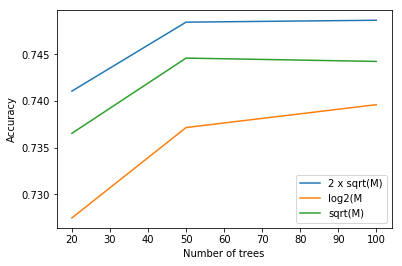

In [19]:
#plotting graphs for Random forest for training on full review
plt.plot(num_trees, accuracy_list['2 sqrt(M)'],label='2 x sqrt(M)')
plt.plot(num_trees, accuracy_list['log2(M)'],label='log2(M')
plt.plot(num_trees, accuracy_list['sqrt(M)'],label='sqrt(M)')
plt.xlabel('Number of trees')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

/usr/local/lib/python3.5/dist-packages/matplotlib/pyplot.py:880: MatplotlibDeprecationWarning: 
Using pyplot.axes(ax) with ax an Axes argument is deprecated. Please use pyplot.sca(ax) instead.
  message="Using pyplot.axes(ax) with ax an Axes "


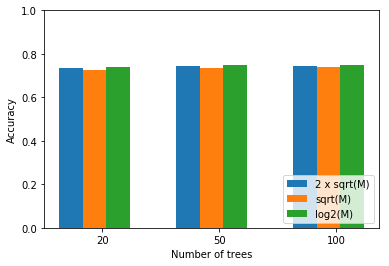

In [20]:
new_list = list(accuracy_list.values())
fig, ax = plt.subplots()
# [20,50,100]
index = np.arange(len(new_list[0]))

p1 = ax.bar(index - 0.2, new_list[0], 0.2, label='2 x sqrt(M)')
p2 = ax.bar(index , new_list[1], 0.2, label='sqrt(M)')
p3 = ax.bar(index + 0.2, new_list[2], 0.2, label='log2(M)')

ax.set_xticks(index + 0.2/3)
ax.set_xticklabels(['20', '50', '100'])
ax.set_ylim(0, 1)
ax.set_xlabel('Number of trees')
ax.set_ylabel('Accuracy')

plt.axes(ax)

plt.legend(loc='lower right')
plt.show()

## Training Random forest on Summary
- we now train our model on review summary


In [21]:
%%time
#
_,features = X_test_summary.shape
accuracy_list_summary = {}


## our grid exaustive search parameters
m_features_names = ["2 sqrt(M)", "sqrt(M)", "log2(M)"]
m_features = [int(2*math.sqrt(features)), int(math.sqrt(features)), int(math.log2(features))]
num_trees = [20,50,100]

for m,m_name in zip(m_features,m_features_names):
    accuracy_list_summary[m_name] = []
    for tr in num_trees:
        rfc_rating = RandomForestClassifier(n_estimators=tr,max_features=m,n_jobs=-1,verbose=3, random_state=42 )
        rfc_rating.fit(X_train_summary, y_train)
        accuracy = rfc_rating.score(X_test_summary, y_test)
        accuracy_list_summary[m_name].append(accuracy)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.


building tree 1 of 20building tree 2 of 20
building tree 3 of 20
building tree 4 of 20

building tree 5 of 20
building tree 6 of 20
building tree 7 of 20
building tree 8 of 20
building tree 9 of 20
building tree 10 of 20
building tree 11 of 20
building tree 12 of 20
building tree 13 of 20
building tree 14 of 20
building tree 15 of 20
building tree 16 of 20
building tree 17 of 20
building tree 18 of 20
building tree 19 of 20
building tree 20 of 20


[Parallel(n_jobs=-1)]: Done   3 out of  20 | elapsed:   17.8s remaining:  1.7min
[Parallel(n_jobs=-1)]: Done  10 out of  20 | elapsed:   18.1s remaining:   18.1s
[Parallel(n_jobs=-1)]: Done  17 out of  20 | elapsed:   30.2s remaining:    5.3s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   30.5s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   3 out of  20 | elapsed:    0.1s remaining:    0.6s
[Parallel(n_jobs=16)]: Done  10 out of  20 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=16)]: Done  17 out of  20 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=16)]: Done  20 out of  20 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.


building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 

[Parallel(n_jobs=-1)]: Done  36 out of  50 | elapsed:   53.8s remaining:   20.9s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  1.1min finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  36 out of  50 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=16)]: Done  50 out of  50 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.


building tree 1 of 100building tree 2 of 100building tree 3 of 100
building tree 4 of 100
building tree 5 of 100

building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100

building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
b

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.0min finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.


building tree 1 of 20building tree 2 of 20building tree 3 of 20building tree 4 of 20building tree 5 of 20building tree 6 of 20building tree 7 of 20
building tree 8 of 20


building tree 9 of 20
building tree 10 of 20

building tree 11 of 20building tree 12 of 20



building tree 13 of 20
building tree 14 of 20
building tree 15 of 20

building tree 16 of 20
building tree 17 of 20
building tree 18 of 20
building tree 19 of 20
building tree 20 of 20


[Parallel(n_jobs=-1)]: Done   3 out of  20 | elapsed:   15.5s remaining:  1.5min
[Parallel(n_jobs=-1)]: Done  10 out of  20 | elapsed:   15.8s remaining:   15.8s
[Parallel(n_jobs=-1)]: Done  17 out of  20 | elapsed:   26.1s remaining:    4.6s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   26.5s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   3 out of  20 | elapsed:    0.1s remaining:    0.6s
[Parallel(n_jobs=16)]: Done  10 out of  20 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=16)]: Done  17 out of  20 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=16)]: Done  20 out of  20 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.


building tree 1 of 50building tree 2 of 50building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50

building tree 13 of 50building tree 14 of 50


building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50building tree 27 of 50

building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 

[Parallel(n_jobs=-1)]: Done  36 out of  50 | elapsed:   46.1s remaining:   17.9s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   57.0s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  36 out of  50 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=16)]: Done  50 out of  50 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.


building tree 1 of 100
building tree 2 of 100
building tree 3 of 100building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100

building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100building tree 29 of 100

building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
b

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.7min finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.


building tree 1 of 20building tree 2 of 20
building tree 3 of 20
building tree 4 of 20building tree 5 of 20
building tree 6 of 20
building tree 7 of 20
building tree 8 of 20
building tree 9 of 20
building tree 10 of 20

building tree 11 of 20
building tree 12 of 20

building tree 13 of 20
building tree 14 of 20
building tree 15 of 20
building tree 16 of 20
building tree 17 of 20
building tree 18 of 20
building tree 19 of 20


[Parallel(n_jobs=-1)]: Done   3 out of  20 | elapsed:   13.5s remaining:  1.3min


building tree 20 of 20


[Parallel(n_jobs=-1)]: Done  10 out of  20 | elapsed:   13.8s remaining:   13.8s
[Parallel(n_jobs=-1)]: Done  17 out of  20 | elapsed:   22.8s remaining:    4.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   23.1s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   3 out of  20 | elapsed:    0.2s remaining:    1.3s
[Parallel(n_jobs=16)]: Done  10 out of  20 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=16)]: Done  17 out of  20 | elapsed:    0.4s remaining:    0.1s
[Parallel(n_jobs=16)]: Done  20 out of  20 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.


building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 

[Parallel(n_jobs=-1)]: Done  36 out of  50 | elapsed:   40.9s remaining:   15.9s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   50.4s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  36 out of  50 | elapsed:    0.6s remaining:    0.3s
[Parallel(n_jobs=16)]: Done  50 out of  50 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.


building tree 1 of 100building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100

building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
b

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.5min finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.


CPU times: user 2h 13min 16s, sys: 5.74 s, total: 2h 13min 22s
Wall time: 9min 38s


[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    1.5s finished


In [22]:
# printing our accuracy list dictionary
accuracy_list_summary
# max accuracy reached was 0.7350 at 100 trees and m = 2sqrt(M)
# results may vary every time

{'2 sqrt(M)': [0.7277215687007911, 0.7334817003609433, 0.7351461539900133],
 'log2(M)': [0.7206523162087861, 0.7310130725065923, 0.7325279123263078],
 'sqrt(M)': [0.7262628340595837, 0.7321538778029212, 0.7344354883955789]}

**Max accuracy was reached at 100 trees with m= 2sqrt(M)**
**Accuracy was aprox 73.51%**

Note values might differ a bit every time due to randomness in building trees

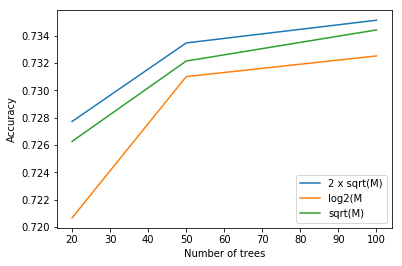

In [23]:
plt.plot(num_trees, accuracy_list_summary['2 sqrt(M)'],label='2 x sqrt(M)')
plt.plot(num_trees, accuracy_list_summary['log2(M)'],label='log2(M')
plt.plot(num_trees, accuracy_list_summary['sqrt(M)'],label='sqrt(M)')
plt.xlabel('Number of trees')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

/usr/local/lib/python3.5/dist-packages/matplotlib/pyplot.py:880: MatplotlibDeprecationWarning: 
Using pyplot.axes(ax) with ax an Axes argument is deprecated. Please use pyplot.sca(ax) instead.
  message="Using pyplot.axes(ax) with ax an Axes "


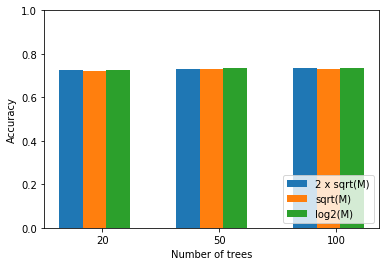

In [24]:
new_list = list(accuracy_list_summary.values())
fig, ax = plt.subplots()

index = np.arange(len(new_list[0]))

p1 = ax.bar(index - 0.2, new_list[0], 0.2, label='2 x sqrt(M)')
p2 = ax.bar(index , new_list[1], 0.2, label='sqrt(M)')
p3 = ax.bar(index + 0.2, new_list[2], 0.2, label='log2(M)')

ax.set_xticks(index + 0.2/3)
ax.set_xticklabels(['20', '50', '100'])
ax.set_ylim(0, 1)
ax.set_xlabel('Number of trees')
ax.set_ylabel('Accuracy')

plt.axes(ax)

plt.legend(loc='lower right')
plt.show()

## XG-Boost for prediction of rating
- we predict rating on the basis of summarized review. (For XGBoost Classifier)

In [25]:
# Assign labels y_train and y_test
y_train = df_train.rating.copy(deep=True)
y_test = df_test.rating.copy(deep=True)

In [26]:
%%time

from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

acc_list = []
max_depth = [10,15,20]
for md in max_depth:
    print("Started training model")
    model = XGBClassifier(max_depth = md)
    model.fit(X_train_summary, y_train)
    y_pred = model.predict(X_test_summary)
    predictions = [round(value) for value in y_pred]
    accuracy = accuracy_score(y_test, predictions)
    print("Accuracy for model with depth ",md," is :",accuracy)
    acc_list.append(accuracy)
    

Started training model
Accuracy for model with depth  10  is : 0.4237250098184062
Started training model
Accuracy for model with depth  15  is : 0.49524041068990665
Started training model
Accuracy for model with depth  20  is : 0.5600979970451273
CPU times: user 2h 17min 16s, sys: 2.44 s, total: 2h 17min 18s
Wall time: 2h 17min 17s


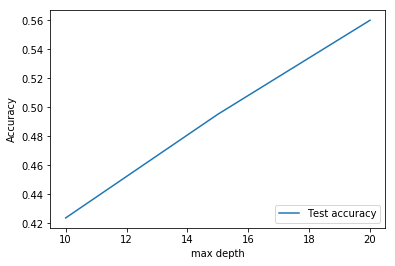

In [27]:
#plotting graphs for xgBoost on rating prediction
plt.plot(max_depth, acc_list,label='Test accuracy')
plt.xlabel('max depth')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

**Max accuracy reached was at max_depth=20, Accuracy was aprox 56%** 

Training time for XGBoost was quite high so we decided not to further tune the hyperparameters.

## Neural network
- we train our neural network on full review and on summary of review
 to predict rating

In [28]:
def get_model(X,shape=10):
    model = Sequential()

    # Dense-1
    model.add(Dense(500, input_shape=(X.shape[1],)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.5))

    # Dense-2
    model.add(Dense(300))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.5))

    # Dense-3
    model.add(Dense(shape, activation='sigmoid'))
    return model


In [29]:
#One hot encoding our output
oe = OneHotEncoder()
y_train = oe.fit_transform(np.array(y_train).reshape(-1,1))
y_test = oe.transform(np.array(y_test).reshape(-1,1))

/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [30]:
model = get_model(X_train)
model.compile(loss='categorical_crossentropy', metrics=['acc'], optimizer=Adam(lr=0.01))

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001)

def lr_schedule(epoch):
    if(epoch <= 5):
        return 1e-2
    elif(epoch <= 10):
        return 1e-3
    elif(epoch <= 15):
        return 1e-4
    else:
        return 1e-5
    
keras.callbacks.LearningRateScheduler(lr_schedule)
model_history = model.fit(X_train, y_train, epochs=20, batch_size=256, validation_data=(X_test, y_test))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 160398 samples, validate on 53471 samples
Epoch 1/20
160398/160398 [==============================] - 92s 571us/step - loss: 1.6412 - acc: 0.4132 - val_loss: 1.4790 - val_acc: 0.4672
Epoch 2/20
160398/160398 [==============================] - 90s 560us/step - loss: 1.2887 - acc: 0.5364 - val_loss: 1.3079 - val_acc: 0.5530
Epoch 3/20
160398/160398 [==============================] - 89s 557us/step - loss: 0.9738 - acc: 0.6596 - val_loss: 1.1838 - val_acc: 0.6199
Epoch 4/20
160398/160398 [==============================] - 89s 553us/step - loss: 0.7291 - acc: 0.7507 - val_loss: 1.1073 - val_acc: 0.6636
Epoch 5/20
160398/160398 [==============================] - 89s 555us/step - loss: 0.5782 - acc: 0.8063 - val_loss: 1.0649 - val_acc: 0.6950
Epoch 6/20
160398/160398 [==============================] - 88s 552u

**Accuracy on test reached after 20 epoch 74.01%**

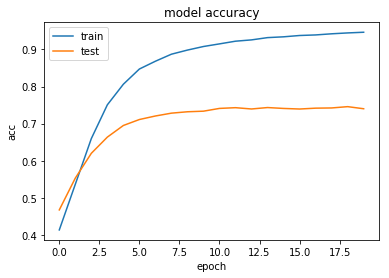

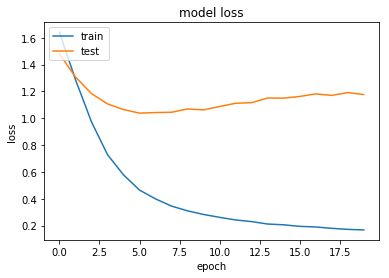

In [31]:
# summarize history for accuracy
plt.plot(model_history.history['acc'])
plt.plot(model_history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Prediction of rating based on summary
- using neural network

In [33]:
model = get_model(X_train_summary)
model.compile(loss='categorical_crossentropy', metrics=['acc'], optimizer=Adam(lr=0.01))
    
keras.callbacks.LearningRateScheduler(lr_schedule)
model_history_summary= model.fit(X_train_summary, y_train, epochs=20, batch_size=256, validation_data=(X_test_summary, y_test))

Train on 160398 samples, validate on 53471 samples
Epoch 1/20
160398/160398 [==============================] - 45s 281us/step - loss: 1.7961 - acc: 0.3653 - val_loss: 1.6751 - val_acc: 0.4054
Epoch 2/20
160398/160398 [==============================] - 45s 283us/step - loss: 1.5450 - acc: 0.4473 - val_loss: 1.5557 - val_acc: 0.4614
Epoch 3/20
160398/160398 [==============================] - 45s 281us/step - loss: 1.3165 - acc: 0.5372 - val_loss: 1.4470 - val_acc: 0.5148
Epoch 4/20
160398/160398 [==============================] - 45s 280us/step - loss: 1.0958 - acc: 0.6242 - val_loss: 1.3665 - val_acc: 0.5642
Epoch 5/20
160398/160398 [==============================] - 46s 285us/step - loss: 0.9294 - acc: 0.6844 - val_loss: 1.2933 - val_acc: 0.5985
Epoch 6/20
160398/160398 [==============================] - 45s 280us/step - loss: 0.8042 - acc: 0.7308 - val_loss: 1.2538 - val_acc: 0.6234
Epoch 7/20
160398/160398 [==============================] - 44s 276us/step - loss: 0.7093 - acc: 0.7636

Training neural network on summary of reviews

**Accuracy after 20 epochs, on test set was 70.50%**

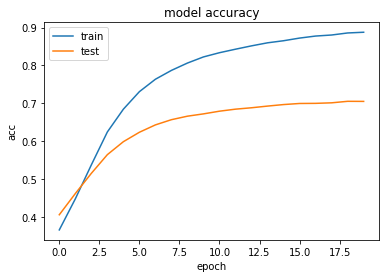

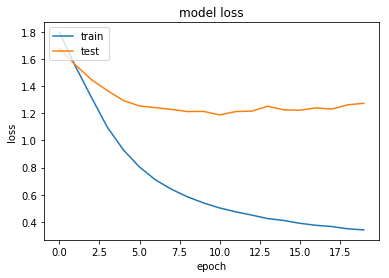

In [34]:
# summarize history for accuracy
plt.plot(model_history_summary.history['acc'])
plt.plot(model_history_summary.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(model_history_summary.history['loss'])
plt.plot(model_history_summary.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Train our models on sentiments
- we now train our model on review sentiments, which were created using vader analyzer
- Since sentiments are extracted from summarized reviews, we train our models on these summarized reviews.


In [35]:
y_train = df_train.sentiment
y_test = df_test.sentiment

## Random forest for sentiment prediction
- we predict sentiment on basis of summary of review

In [37]:
%%time
#
_,features = X_test_summary.shape
accuracy_sentiment_summary = {}


## our grid exaustive search parameters
m_features_names = ["2 sqrt(M)", "sqrt(M)", "log2(M)"]
m_features = [int(2*math.sqrt(features)), int(math.sqrt(features)), int(math.log2(features))]
num_trees = [20,50,100]

for m,m_name in zip(m_features,m_features_names):
    accuracy_sentiment_summary[m_name] = []
    for tr in num_trees:
        rfc_rating = RandomForestClassifier(n_estimators=tr,max_features=m,n_jobs=-1,verbose=3, random_state=42 )
        rfc_rating.fit(X_train_summary, y_train)
        accuracy = rfc_rating.score(X_test_summary, y_test)
        accuracy_sentiment_summary[m_name].append(accuracy)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.


building tree 1 of 20
building tree 2 of 20
building tree 3 of 20
building tree 4 of 20
building tree 5 of 20
building tree 6 of 20
building tree 7 of 20
building tree 8 of 20
building tree 9 of 20
building tree 10 of 20
building tree 11 of 20
building tree 12 of 20
building tree 13 of 20
building tree 14 of 20
building tree 15 of 20
building tree 16 of 20
building tree 17 of 20
building tree 18 of 20
building tree 19 of 20
building tree 20 of 20


[Parallel(n_jobs=-1)]: Done   3 out of  20 | elapsed:   11.5s remaining:  1.1min
[Parallel(n_jobs=-1)]: Done  10 out of  20 | elapsed:   11.8s remaining:   11.8s
[Parallel(n_jobs=-1)]: Done  17 out of  20 | elapsed:   19.3s remaining:    3.4s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   20.0s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   3 out of  20 | elapsed:    0.1s remaining:    0.4s
[Parallel(n_jobs=16)]: Done  10 out of  20 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=16)]: Done  17 out of  20 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=16)]: Done  20 out of  20 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.


building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 

[Parallel(n_jobs=-1)]: Done  36 out of  50 | elapsed:   34.9s remaining:   13.6s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   43.1s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  36 out of  50 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=16)]: Done  50 out of  50 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.


building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
b

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.3min finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.


building tree 1 of 20
building tree 2 of 20
building tree 3 of 20
building tree 4 of 20
building tree 5 of 20
building tree 6 of 20
building tree 7 of 20
building tree 8 of 20
building tree 9 of 20
building tree 10 of 20
building tree 11 of 20
building tree 12 of 20
building tree 13 of 20
building tree 14 of 20
building tree 15 of 20
building tree 16 of 20
building tree 17 of 20
building tree 18 of 20
building tree 19 of 20
building tree 20 of 20


[Parallel(n_jobs=-1)]: Done   3 out of  20 | elapsed:   10.1s remaining:   57.5s
[Parallel(n_jobs=-1)]: Done  10 out of  20 | elapsed:   10.3s remaining:   10.3s
[Parallel(n_jobs=-1)]: Done  17 out of  20 | elapsed:   17.1s remaining:    3.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   17.3s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   3 out of  20 | elapsed:    0.1s remaining:    0.5s
[Parallel(n_jobs=16)]: Done  10 out of  20 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=16)]: Done  17 out of  20 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=16)]: Done  20 out of  20 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.


building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 

[Parallel(n_jobs=-1)]: Done  36 out of  50 | elapsed:   30.2s remaining:   11.7s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   37.3s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  36 out of  50 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=16)]: Done  50 out of  50 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.


building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
b

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.1min finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.


building tree 1 of 20
building tree 2 of 20
building tree 3 of 20
building tree 4 of 20
building tree 5 of 20
building tree 6 of 20
building tree 7 of 20
building tree 8 of 20
building tree 9 of 20
building tree 10 of 20
building tree 11 of 20
building tree 12 of 20
building tree 13 of 20
building tree 14 of 20
building tree 15 of 20
building tree 16 of 20
building tree 17 of 20
building tree 18 of 20
building tree 19 of 20
building tree 20 of 20


[Parallel(n_jobs=-1)]: Done   3 out of  20 | elapsed:    8.7s remaining:   49.4s
[Parallel(n_jobs=-1)]: Done  10 out of  20 | elapsed:    9.0s remaining:    9.0s
[Parallel(n_jobs=-1)]: Done  17 out of  20 | elapsed:   14.7s remaining:    2.6s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   14.9s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   3 out of  20 | elapsed:    0.2s remaining:    1.1s
[Parallel(n_jobs=16)]: Done  10 out of  20 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=16)]: Done  17 out of  20 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=16)]: Done  20 out of  20 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.


building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50building tree 7 of 50building tree 8 of 50
building tree 9 of 50building tree 10 of 50
building tree 11 of 50

building tree 12 of 50
building tree 13 of 50

building tree 14 of 50
building tree 15 of 50

building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50building tree 29 of 50

building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 

[Parallel(n_jobs=-1)]: Done  36 out of  50 | elapsed:   26.4s remaining:   10.3s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   32.3s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  36 out of  50 | elapsed:    0.6s remaining:    0.2s
[Parallel(n_jobs=16)]: Done  50 out of  50 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.


building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
b

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   59.1s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.


CPU times: user 1h 26min 16s, sys: 756 ms, total: 1h 26min 17s
Wall time: 6min 19s


[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    1.3s finished


In [38]:
accuracy_sentiment_summary

{'2 sqrt(M)': [0.8640758542013428, 0.8710141946101625, 0.8730152793102803],
 'log2(M)': [0.8414654672626284, 0.8431299208916984, 0.8395765929195265],
 'sqrt(M)': [0.8543509565932935, 0.8599614744440912, 0.8613454021806213]}

**Maximum accuracy was found at 100 trees and m = 2sqrt(M).... Accuracy was 87.30% approx**

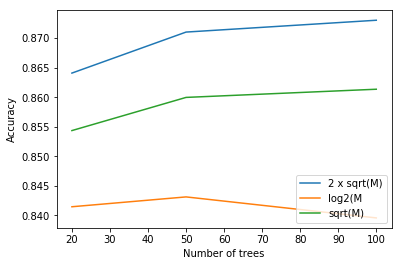

In [39]:
plt.plot(num_trees, accuracy_sentiment_summary['2 sqrt(M)'],label='2 x sqrt(M)')
plt.plot(num_trees, accuracy_sentiment_summary['log2(M)'],label='log2(M')
plt.plot(num_trees, accuracy_sentiment_summary['sqrt(M)'],label='sqrt(M)')
plt.xlabel('Number of trees')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

/usr/local/lib/python3.5/dist-packages/matplotlib/pyplot.py:880: MatplotlibDeprecationWarning: 
Using pyplot.axes(ax) with ax an Axes argument is deprecated. Please use pyplot.sca(ax) instead.
  message="Using pyplot.axes(ax) with ax an Axes "


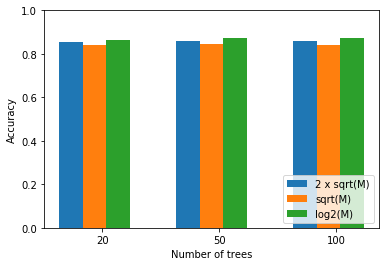

In [40]:
new_list = list(accuracy_sentiment_summary.values())
fig, ax = plt.subplots()
index = np.arange(len(new_list[0]))

p1 = ax.bar(index - 0.2, new_list[0], 0.2, label='2 x sqrt(M)')
p2 = ax.bar(index , new_list[1], 0.2, label='sqrt(M)')
p3 = ax.bar(index + 0.2, new_list[2], 0.2, label='log2(M)')

ax.set_xticks(index + 0.2/3)
ax.set_xticklabels(['20', '50', '100'])
ax.set_ylim(0, 1)
ax.set_xlabel('Number of trees')
ax.set_ylabel('Accuracy')

plt.axes(ax)

plt.legend(loc='lower right')
plt.show()

# Naive bayes classsifier for sentiment
- we predict semtiment on basis of review summary

In [41]:
%%time
from sklearn.naive_bayes import MultinomialNB
accuracy_nb_summary = {}


## our grid exaustive search parameters
fit_prior = [True, False]
alpha = [0.001,0.01,0.05,0.1,0.5,1,2,3,5,10] #m-value

for prior in fit_prior:
    accuracy_nb_summary[prior] = []
    for a in alpha:
        nb_classifier = MultinomialNB(alpha=a, fit_prior=prior)
        nb_classifier.fit(X_train_summary, y_train)
        accuracy = nb_classifier.score(X_test_summary, y_test)
        accuracy_nb_summary[prior].append(accuracy)


CPU times: user 16 s, sys: 28 ms, total: 16 s
Wall time: 16 s


In [42]:
accuracy_nb_summary

{False: [0.6339511136877933,
  0.6350358138056142,
  0.6376727571954891,
  0.6399730695143162,
  0.6533822071777226,
  0.6605449683005742,
  0.6541489779506648,
  0.6386078435039554,
  0.6110976043088777,
  0.5816236838660208],
 True: [0.6637242617493595,
  0.6621533167511361,
  0.6575526921134821,
  0.6533074002730452,
  0.6315198892857811,
  0.6127994613902863,
  0.5888986553458885,
  0.5760131660152232,
  0.5653344803725384,
  0.5583400347852107]}

**Maximum accuracy was found at fit_prior=True, alpha = 0.01.... Accuracy was 66.37% approx**

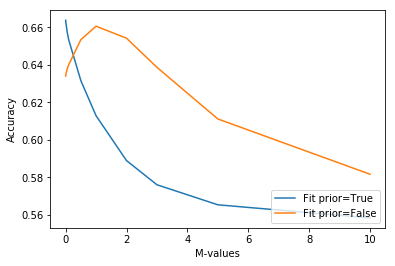

In [43]:
plt.plot(alpha, accuracy_nb_summary[True],label='Fit prior=True')
plt.plot(alpha, accuracy_nb_summary[False],label='Fit prior=False')
plt.xlabel('M-values')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

## XG-boost for prediction of sentiment


In [44]:
y_train = df_train.sentiment
y_test = df_test.sentiment

le = LabelEncoder()

y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)


In [45]:
%%time

from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

acc_list = []
max_depth = [10,15,20]
for md in max_depth:
    print("Started training model")
    model = XGBClassifier(max_depth = md)
    model.fit(X_train_summary, y_train)
    y_pred = model.predict(X_test_summary)
    predictions = [round(value) for value in y_pred]
    accuracy = accuracy_score(y_test, predictions)
    print("Accuracy for model with depth ",md," is :",accuracy)
    acc_list.append(accuracy)
    

Started training model
Accuracy for model with depth  10  is : 0.7596080118194909
Started training model
Accuracy for model with depth  15  is : 0.8081202895027211
Started training model
Accuracy for model with depth  20  is : 0.8395391894671879
CPU times: user 45min 37s, sys: 696 ms, total: 45min 37s
Wall time: 45min 36s


**Max accuracy reached was at max_depth=20 , Accuracy was approx 83.95%** 

Training time for xg boost was quite high so we decided not to further tune the model.

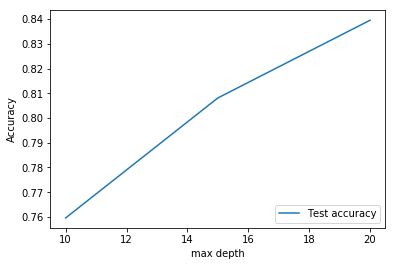

In [46]:
#plotting graphs for xgBoost on rating prediction
plt.plot(max_depth, acc_list,label='Test accuracy')
plt.xlabel('max depth')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# Neural network
- For sentiment prediction based on review summary

In [48]:
#One hot encoding our output
oe = OneHotEncoder()

y_train = oe.fit_transform(y_train.reshape(-1,1))
y_test = oe.transform(y_test.reshape(-1,1))

/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [49]:
#define our model
model = get_model(X_train_summary,shape=3)
model.compile(loss='categorical_crossentropy', metrics=['acc'], optimizer=Adam(lr=0.01))
    
# Train our model
keras.callbacks.LearningRateScheduler(lr_schedule)
model_history_sentiment= model.fit(X_train_summary, y_train, epochs=20, \
                                   batch_size=256, validation_data=(X_test_summary, y_test))  

Train on 160398 samples, validate on 53471 samples
Epoch 1/20
160398/160398 [==============================] - 31s 195us/step - loss: 0.6437 - acc: 0.6326 - val_loss: 0.5265 - val_acc: 0.6859
Epoch 2/20
160398/160398 [==============================] - 31s 191us/step - loss: 0.4479 - acc: 0.7314 - val_loss: 0.4658 - val_acc: 0.7171
Epoch 3/20
160398/160398 [==============================] - 31s 192us/step - loss: 0.3243 - acc: 0.8549 - val_loss: 0.3801 - val_acc: 0.8582
Epoch 4/20
160398/160398 [==============================] - 31s 192us/step - loss: 0.2295 - acc: 0.9104 - val_loss: 0.3708 - val_acc: 0.8754
Epoch 5/20
160398/160398 [==============================] - 30s 190us/step - loss: 0.1732 - acc: 0.9337 - val_loss: 0.3651 - val_acc: 0.8839
Epoch 6/20
160398/160398 [==============================] - 30s 189us/step - loss: 0.1470 - acc: 0.9440 - val_loss: 0.3690 - val_acc: 0.8805
Epoch 7/20
160398/160398 [==============================] - 30s 190us/step - loss: 0.1239 - acc: 0.9541

**Accuracy reached with neural network, on test set for sentiment prediction was 90.28%**

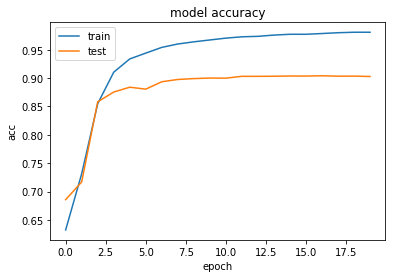

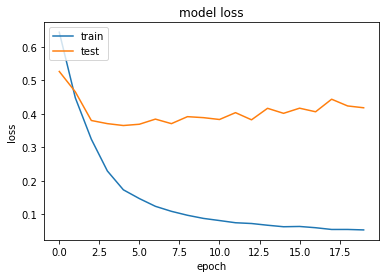

In [50]:
#plot graphs
# summarize history for accuracy
plt.plot(model_history_sentiment.history['acc'])
plt.plot(model_history_sentiment.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(model_history_sentiment.history['loss'])
plt.plot(model_history_sentiment.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Data Exploration Analysis can be found in *exploratory_data_analysis.ipynb* file